In [543]:
using CSV, DataFrames, Plots
dat = CSV.read("../processed_data/kelp_bins_50_500m_cenca.csv",DataFrame)[:,2:22]
dat[1:4,:]

Row,year,lat_36_00000,lat_36_00450,lat_36_00900,lat_36_01350,lat_36_01800,lat_36_02250,lat_36_02700,lat_36_03150,lat_36_03600,lat_36_04050,lat_36_04500,lat_36_05849,lat_36_06299,lat_36_06749,lat_36_07199,lat_36_07649,lat_36_08099,lat_36_08549,lat_36_08999,lat_36_09449
,Int64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,1984,0.0,0.0160396,0.0978613,0.0109115,0.0239917,0.0176088,0.00084845,0.0153562,0.00691837,0.0146774,0.0,0.0,0.000191485,0.185219,0.0329401,0.0360739,0.0202476,0.0396981,0.000878029,0.0
2,1985,0.00441972,0.0910208,0.686402,0.40914,0.266854,0.210356,0.0850163,0.236652,0.0807709,0.110026,0.00273216,0.0,0.0316526,0.441354,0.187838,0.0998089,0.138473,0.115202,0.0494857,0.0134631
3,1986,0.000140111,0.0321742,0.299255,0.313484,0.235165,0.124272,0.0681983,0.191286,0.0227587,0.0214354,9.34073e-5,0.0,0.00298592,0.0932236,0.0290933,0.0184573,0.0494,0.014693,0.012719,0.00127657
4,1987,0.000568228,0.0894515,0.363398,0.331092,0.253364,0.128552,0.101875,0.21297,0.0386084,0.0350807,0.000474821,0.0,0.011556,0.249172,0.082021,0.0546386,0.069576,0.0492957,0.00599052,0.00463923


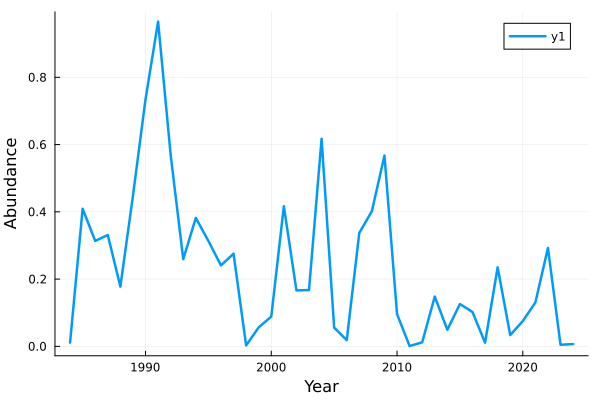

In [544]:
Plots.plot(dat.year, dat.lat_36_01350, width = 2.5, xlabel = "Year", ylabel = "Abundance")

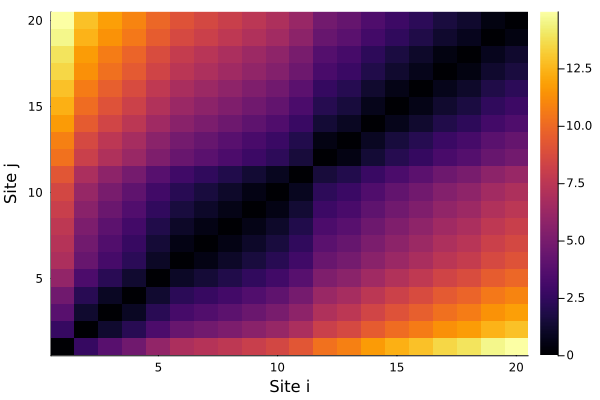

In [546]:
dists = CSV.read("../processed_data/kelp_bins_50_500m_cenca_dists.csv",DataFrame)[1:20,:2:21]
Plots.heatmap(Matrix(dists), xlabel = "Site i", ylabel = "Site j")

In [547]:
X = CSV.read("../processed_data/covars.csv",DataFrame)[:,:2:end]
X[1:4,:]

Row,year,variable,value
,Float64,String7,Float64
1,1980.0,enso,0.33
2,1980.08,enso,0.2
3,1980.17,enso,0.39
4,1980.25,enso,0.51


In [548]:
unique(X.variable)

2-element Vector{String7}:
 "enso"
 "anom"

In [549]:
include("/Users/johnbuckner/.julia/dev/UniversalDiffEq.jl/src/UniversalDiffEq.jl")
include("../src/UDE.jl")
model,NN = init_model_matching(dat,X,Matrix(dists),inv_distance,[1],[3];hidden = 7)

α = UniversalDiffEq.train!(model, loss_function = "spline gradient matching", 
        regularization_weight = 1e2,
        optim_options = (maxiter = 500, step_size = 0.05), 
        loss_options = (σ = 0.05^2, τ = 0.1^2, T = 160))
nothing

162


2.553825099e6 5.380241001e6 3.372461531e6 4.19889944e6 2.137730242e6 3.055995343e6 2.446626482e6 2.007458635e6 1.984300054e6 1.8312464e6 1.94024245e6 1.992054252e6 1.633808279e6 1.312611415e6 1.320197634e6 1.349598131e6 1.271054769e6 1.215598165e6 1.15902778e6 1.080189006e6 1.04537858e6 1.027033526e6 973861.436 911252.064 878147.1 868340.262 848170.667 803125.187 755605.611 727091.922 714152.72 704712.632 683157.173 647694.535 623102.087 617081.652 606652.423 585390.059 568904.4 559593.7 548838.5 536681.289 526565.075 520046.765 515526.187 507663.984 497729.69 491934.483 489443.614 485333.299 478528.5 472342.629 469856.952 468094.655 463699.611 459653.514 458144.672 456513.617 453532.164 451113.127 450113.821 448851.701 446669.294 445172.697 444329.076 442779.094 441004.714 439834.47 438856.21 437458.962 436093.546 435385.173 434775.647 433789.408 432960.109 432439.818 431860.276 431190.33 430702.036 430297.507 429745.918 429172.015 428669.346 428191.084 427663.641 427241.462 426976.75

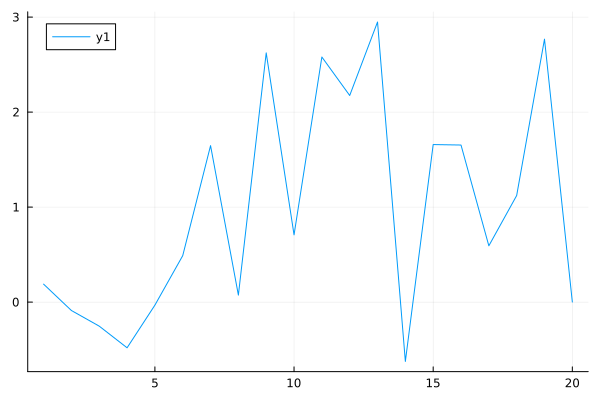

In [550]:
Plots.plot(model.parameters.process_model.FE)

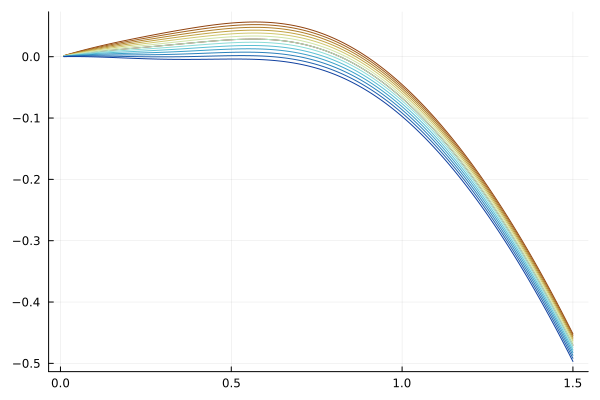

In [555]:
rhs = UniversalDiffEq.get_right_hand_side(model)
K = exp.(model.parameters.process_model.K)
f_rhs = (u,X,site) -> rhs(u.*K, [X,X], 0.0)[site]

Xvals = -3:0.5:3
site = 2
uvals = 0.01:0.0025:1.5
colors = cgrad(:roma)[1:round(Int,256/length(Xvals)-1):256]
p1 = Plots.plot(uvals,f_rhs.(uvals,0.0,site), color = colors[1], label = "")
i = 1
for X in Xvals
    i += 1
    Plots.plot!(p1,uvals,f_rhs.(uvals,X,site), color = colors[i], label = "")
end
p1

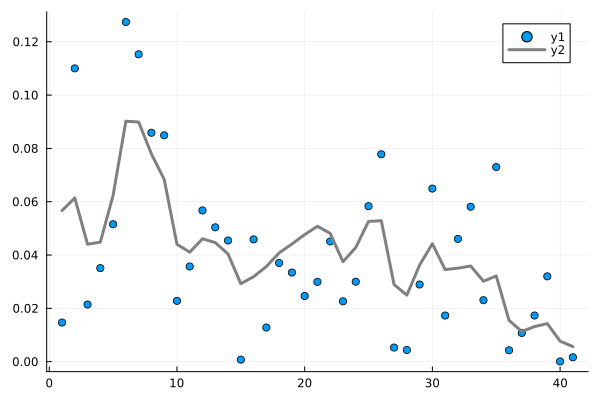

In [557]:
function plot_state_estimates(model,site)
    Plots.scatter(model.data[site,:], c = 1, markersize = 4)
    Plots.plot!(model.parameters.uhat[site,:], color = "grey", linewidth = 3)
end 
plot_state_estimates(model,10)

In [608]:
u = [1,2,3,4,5,6]
K = [1,1,1,1,1,1] * 0.5
n_sites = length(u)
padding = 2
inputs = 0
mean_t = 0
mean_K = 0
i = 3
if i <= padding
    u_ = vcat(zeros(padding-i+1) .+ mean_t,u[1:(i+padding)]) 
    K_ = vcat(zeros(padding-i+1) .+ mean_K,K[1:(i+padding)])
    K_[padding+1] = 1
    inputs = u_.*K_
elseif (n_sites - i) <= padding

    u_ = vcat(u[(i-padding):end],zeros(padding - n_sites +i) .+ mean_t) 
    K_ = vcat(K[(i-padding):end],zeros(padding - n_sites +i) .+ mean_K)
    K_[padding+1] = 1
    inputs = u_.*K_ 
else
    u_ = u[(i-padding):(i+padding)]
    K_ = K[(i-padding):(i+padding)]
    K_[padding+1] = 1
    inputs =u_.*K_
end
inputs

5-element Vector{Float64}:
 0.5
 1.0
 3.0
 2.0
 2.5